In [1]:
import torch

from utils.parsing import parse_snp500
from utils.data import make_loaders, show_data
from utils.training import Logger, trainer, show_quality

from models.UNetBased import UNetBased

# Парсим данные snp500 в папку "data/" если их нет

In [2]:
# # парсим данные за последние 6+ лет (выборка бOльшего размера просто не влезет в память)
# # Данная конфигурация занимает ???гб
# parse_snp500(dirpath='data/', 
#              start='2017-05-01', 
#              timeframe='1d', 
#              max_train_len=256, 
#              test_len=32, 
#              split_coeff=0.1)

# Создаём loader'ы для train и val выборок

In [3]:
# from utils.data import TradingDataset
# from torch.utils.data import DataLoader

# # Получаем датасеты данных для обучения и валидации
# train_dataset = TradingDataset(root_dir="data/train", train_len=256, test_len=32)
# val_dataset = TradingDataset(root_dir="data/val", train_len=256, test_len=32)

# print(f"Train dataset lenght: {len(train_dataset)}\nValidation dataset lenght: {len(val_dataset)}\n")

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# print(f"Train loader lenght: {len(train_loader)}\nValidation loader lenght: {len(val_loader)}")

# Посмотрим на то что хранится в loader'ах

In [4]:
# show_data(val_loader)

# Построим модель

In [5]:
# %run models/UNetBased.py

# myModel = UNetBased(seq_len=256)
# myModel

In [6]:
# train_sample, test_sample = next(iter(train_loader))

# myModel(train_sample).shape, test_sample.shape

In [7]:
# show_quality(myModel, val_loader)

# Обучаем модель

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: grafikxxxxxxxyyyyyyyyyyy. Use `wandb login --relogin` to force relogin


Train dataset lenght: 610868
Validation dataset lenght: 67545

Train loader lenght: 38180
Validation loader lenght: 4222


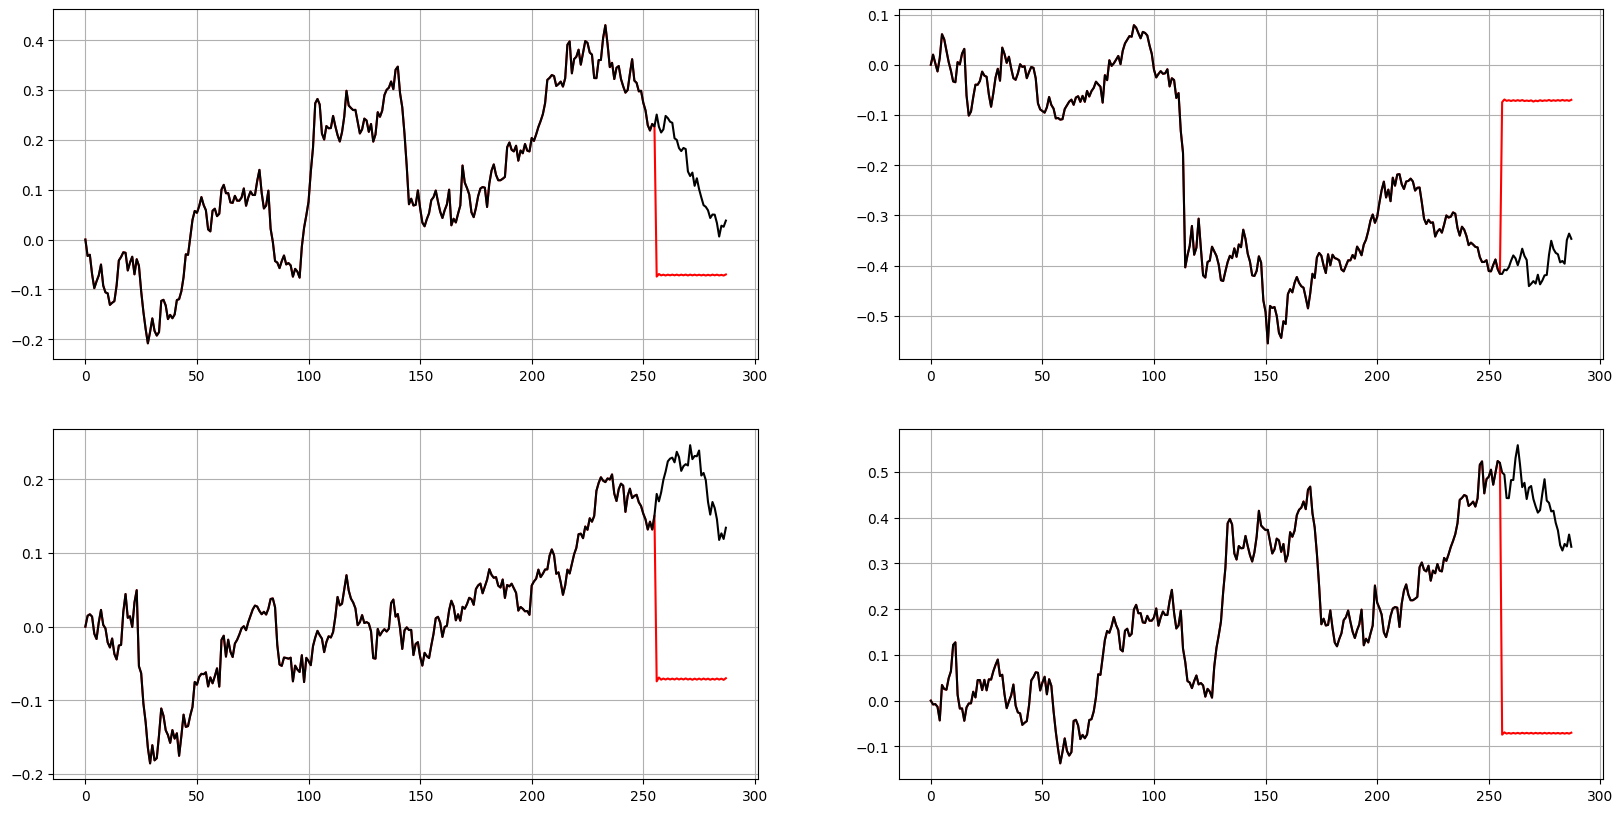

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/var/folders/r_/1p4mfp_168q7t576jlf4wryc0000gn/T/ipykernel_14225/2320522594.py", line 33, in <module>
    trainer(train_loader,
  File "/Users/honeysuckle/dev/Git/TradingEnsemble/utils/training.py", line 208, in trainer
    current_loss = train_epoch(train_loader, model, optim, loss_function, logger)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/honeysuckle/dev/Git/TradingEnsemble/utils/training.py", line 183, in train_epoch
    batch_loss = train_batch(x_batch, y_batch, model, optimizer, loss_function)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/honeysuckle/dev/Git/TradingEnsemble/utils/training.py", line 164, in train_batch
    loss.backward()
  File "/opt/homebrew/lib/python3.11/site-packages/torch/_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "/opt/homebrew/lib/python3.11/site-packages/torch/autograd/__init__.py", 

Loss on TEST,▆▂▂█▂▂▂▂▁▂▂▂▁▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁
Loss on TRAIN,▆▆▂▄▂▃▃▃▂▄▃▃▅▂▃▁▇▆▂▃▁▁▃▁▄▂▂▂▂▂▂▄▁▁▃▃█▂▃▄
Metric MAE,▆▂▂█▂▂▄▃▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▂▁▁▁▂▁▁
Loss on TEST,0.00877
Loss on TRAIN,0.00979
Metric MAE,0.06773


KeyboardInterrupt: 

In [8]:
# import wandb

# configuration = {
#     "train_len": 256,
#     "test_len": 32,
#     "batch_size": 16,
#     "epochs": 10,
#     "learning_rate": 1e-4,
# }

# with wandb.init(config=configuration, project="TradingUNetTest"):
#     # Инициализируем loader'ы
#     train_loader, val_loader = make_loaders(train_len=configuration["train_len"], 
#                                             test_len=configuration["test_len"], 
#                                             batch_size=configuration["batch_size"])

#     # Определяем функцию потерь
#     loss_function = torch.nn.MSELoss()

#     # Определяем оптимизатор
#     optimizer = torch.optim.Adam

#     # Инициализируем модель
#     myModel = UNetBased(seq_len=configuration["train_len"], pred_len=configuration["test_len"])
    
#     # Инициализируем логгер
#     logger = Logger(val_loader, loss_function, metric=torch.nn.L1Loss(), delimeter=1000)
    
#     # Посмотрим на качество необученной модели (необязательно, можно убрать после создания таблиц)
#     show_quality(myModel, val_loader)

#     # Запускаем процесс обучения модели
#     trainer(train_loader, 
#             myModel, 
#             optimizer, 
#             loss_function, 
#             configuration["epochs"], 
#             configuration["learning_rate"], 
#             logger)

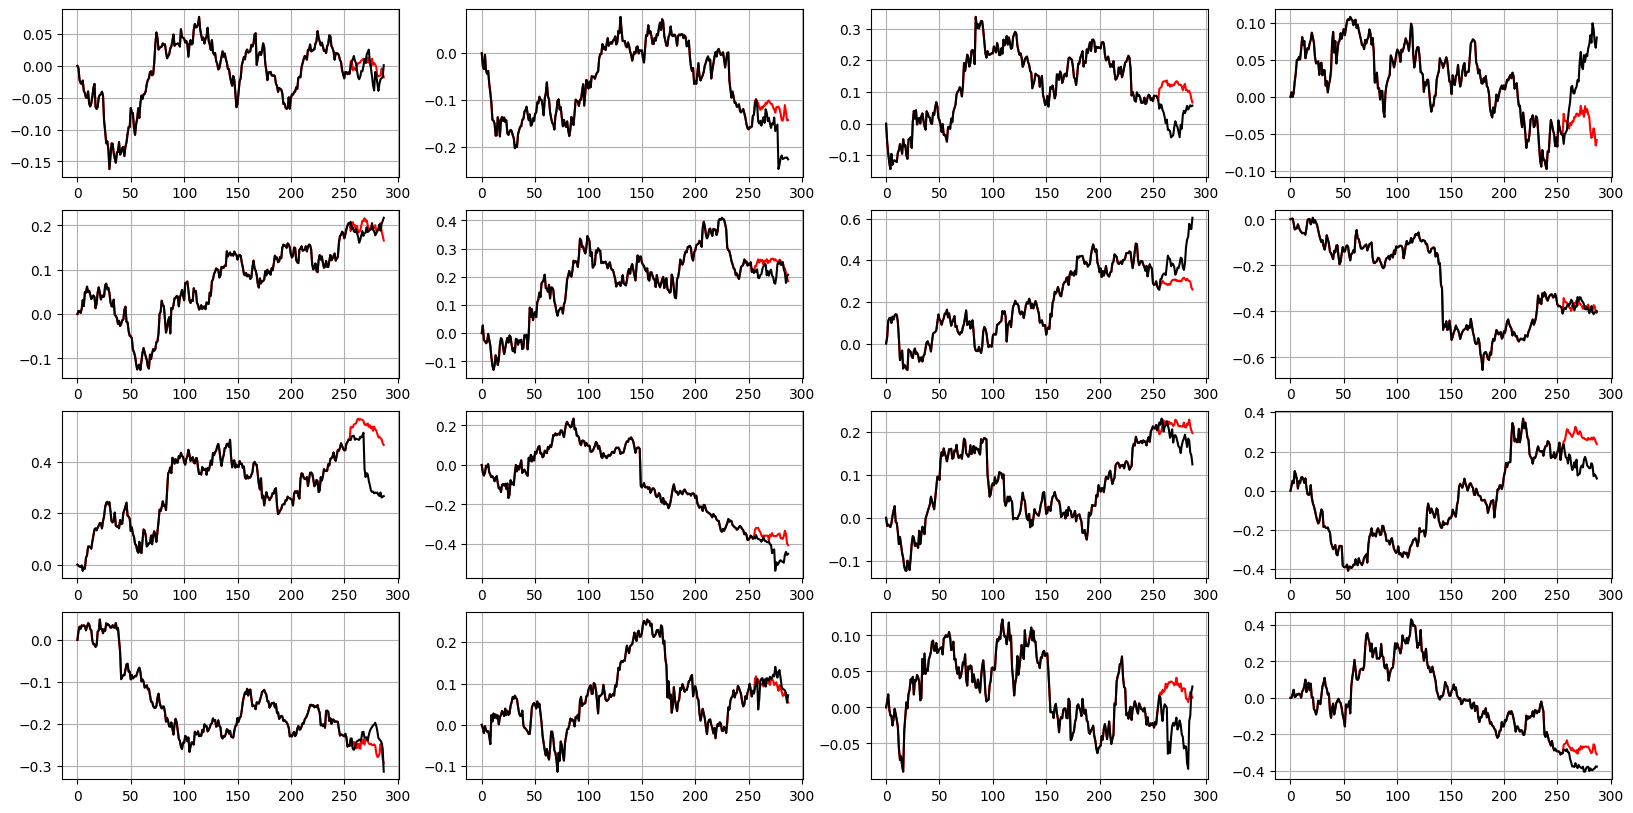

In [14]:
show_quality(myModel, val_loader)